##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [ ]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
orig_df = pd.read_csv('/content/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [ ]:
df = pd.read_csv('/content/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [ ]:

df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [ ]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [ ]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


In [ ]:
df.head(10)

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0
5,-115.132162,36.100841,5,1,3,4,1
6,-115.176012,36.194067,1,1,4,5,2
7,-115.194061,36.135213,3,1,4,3,1
8,-115.069716,36.191304,0,1,5,6,0
9,-115.309341,36.074367,6,1,6,1,0


Explanation of each column:

X and Y: These are the latitude and longitude of the crime incident.
Area_Command: The police designation of the bureau of operation.
NIBRSOffenseCode: Classification code for the crime committed.
DayOfWeek: Day of the week when the crime was reported.
Time: Hour of the day when the crime was reported.
VictimCount: Number of persons involved in the incident.
Identification of input and target variables:

Input variables: X, Y, Area_Command, NIBRSOffenseCode, DayOfWeek, Time
Target variable: VictimCount
Checking the range of values in each column and deciding on scaling, shifting, or normalizing:



In [ ]:
df.describe()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,-115.159326,36.143360,3.978182,0.909091,2.981818,11.236364,0.712727
std,0.101294,0.118418,3.045799,0.334878,1.924590,7.039937,0.978427
min,-116.000000,35.068419,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-115.209198,36.114704,1.000000,1.000000,1.000000,5.000000,0.000000
50%,-115.149945,36.152415,3.000000,1.000000,3.000000,11.000000,0.000000
75%,-115.105200,36.183854,6.000000,1.000000,5.000000,18.000000,1.000000
max,-114.625570,37.000000,11.000000,2.000000,6.000000,23.000000,6.000000



Based on the output, we can see the range of values for each column. If the range is very large for some columns, or if the mean is very far from zero, it would be beneficial to scale and/or normalize the data. This can help in the faster convergence of the neural network and generally lead to better performance.

## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

#Splitting data
X = df.drop(columns=['VictimCount']).values
y = df['VictimCount'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting NumPy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Creating PyTorch Dataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Creating DataLoader objects for efficient data loading during training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Verifying the shape of data by printing the shape of the first batch
for inputs, outputs in train_loader:
    print(inputs.shape, outputs.shape)
    break


torch.Size([32, 6]) torch.Size([32])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

**1. Define the Proper Loss Function for This Task**

To establish the appropriate loss function for a regression task, the Mean Squared Error (MSE) is commonly employed. The MSE calculates the average squared difference between the predicted values generated by the model and the actual values present in the dataset.

**2. What Should the Size of the Predicted Output Be?**

The predicted output should consist of a single continuous value, specifically denoting the forecasted VictimCount for each individual data point. Hence, the predicted output size should be set to 1.

**3. Explain Your Choice of Architecture, Including How Many Layers You Will Be Using**<br>

I have chosen a neural network architecture consisting of multiple fully connected (dense) layers to handle this regression task.

  The presence of multiple hidden layers allows the neural network to capture complex and non-linear patterns in the data, which can be essential for regression tasks where the relationships between input features and the target variable may not be linear.

  The choice of ReLU activation functions after each hidden layer is common in deep learning architectures as they help weaken the vanishing gradient problem and accelerate convergence during training.

  The output layer has a single neuron with a linear activation function, suitable for regression tasks where the goal is to predict a continuous value.

  This architecture provides a good starting point for this regression task. I will further fine tune it.

**4. Define an Optimizer for Training This Model, Choose a Proper Learning Rate**<br>

The Adam optimizer is a popular choice due to its adaptive learning rate features. Initially, I've opted to set the learning rate at 0.001, a common and widely accepted initial value.

**5.Write a Training Loop:**

 In this training loop, we will handle data in batches, calculate both forward and backward passes, and proceed to adjust the model's weights accordingly.


In [ ]:
# Import necessary libraries
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture as a subclass of nn.Module
class RegressionNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RegressionNet, self).__init__()
        # Define the layers of the neural network
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Define the forward pass of the neural network
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc4(x)    # The output layer

# Define hyperparameters
input_size = X_train.shape[1]
hidden_size = 64
learning_rate = 0.001


# Instantiate the model, loss function, and optimizer
model = RegressionNet(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()       # Zero the gradients to avoid accumulation
        outputs = model(inputs).squeeze()    # Perform a forward pass and remove any single-dimensional output
        loss = criterion(outputs, labels)    # Calculate the loss between predicted and actual values
        loss.backward()         # Backpropagate the gradients
        optimizer.step()        # Update model parameters using the optimizer

    # Testing loop for each epoch
    model.eval()    # Set the model to evaluation mode (no gradient computation)
    total_loss = 0  # Initialize a variable to accumulate the loss
    with torch.no_grad():  # Disable gradient computation for testing
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()   # Perform a forward pass and remove any single-dimensional output
            loss = criterion(outputs, labels)   # Calculate the loss between predicted and actual values
            total_loss += loss.item()           # Accumulate the loss
    avg_loss = total_loss / len(test_loader)    # Calculate the average loss for this epoch's testing
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")    # Print the epoch number and average loss


Epoch 1/100, Loss: 0.9452
Epoch 2/100, Loss: 0.9793
Epoch 3/100, Loss: 0.9388
Epoch 4/100, Loss: 0.9933
Epoch 5/100, Loss: 0.9448
Epoch 6/100, Loss: 0.9836
Epoch 7/100, Loss: 1.0288
Epoch 8/100, Loss: 0.9371
Epoch 9/100, Loss: 0.9715
Epoch 10/100, Loss: 1.0906
Epoch 11/100, Loss: 0.9368
Epoch 12/100, Loss: 0.9547
Epoch 13/100, Loss: 0.9419
Epoch 14/100, Loss: 1.0372
Epoch 15/100, Loss: 1.0157
Epoch 16/100, Loss: 0.9858
Epoch 17/100, Loss: 0.9474
Epoch 18/100, Loss: 0.9478
Epoch 19/100, Loss: 0.9687
Epoch 20/100, Loss: 0.9863
Epoch 21/100, Loss: 0.9475
Epoch 22/100, Loss: 0.9468
Epoch 23/100, Loss: 0.9861
Epoch 24/100, Loss: 1.0047
Epoch 25/100, Loss: 0.9582
Epoch 26/100, Loss: 0.9561
Epoch 27/100, Loss: 0.9513
Epoch 28/100, Loss: 1.0570
Epoch 29/100, Loss: 1.0281
Epoch 30/100, Loss: 1.0121
Epoch 31/100, Loss: 0.9545
Epoch 32/100, Loss: 0.9524
Epoch 33/100, Loss: 1.0213
Epoch 34/100, Loss: 0.9557
Epoch 35/100, Loss: 0.9521
Epoch 36/100, Loss: 0.9508
Epoch 37/100, Loss: 0.9622
Epoch 38/1

In this model the MSE is slightly on the higher side so I will try to improve it making following changes:

**Change in activation function:** Use the LeakyReLU activation function. LeakyReLU addresses the problem of dying neurons encountered in ReLU (where neurons can become inactive and only output 0). This can lead to a more effective training process.

**Apply Dropout:** Apply dropout (nn.Dropout) with a probability of 0.5 after the first ReLU activation.Dropout is a regularization technique that helps prevent overfitting.

**Increase hidden layer size:**A larger network with more parameters can potentially model complex relationships in the data better.

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture with improvements
class RegressionNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RegressionNet, self).__init__()
        #Defining Layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(hidden_size, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)


    def forward(self, x):
        x = self.relu((self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.relu((self.fc3(x)))
        return self.fc4(x)


input_size = X_train.shape[1]  # Number of input features
hidden_size = 256

# Instantiate the model, loss function, and optimizer
model = RegressionNet(input_size, hidden_size)   # Create an instance of the neural network
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)   # Calculate the MSE loss between predicted and actual values
        loss.backward()     # Backpropagate the gradients
        optimizer.step()    # Update model parameters using the optimizer
        total_loss += loss.item()   # Accumulate the training loss

    scheduler.step()  # Update the learning rate

    # Validation loop
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)         # Perform a forward pass for validation
            val_loss = criterion(outputs, labels)   # Calculate the validation loss
            total_val_loss += val_loss.item()       # Accumulate the validation loss

    avg_train_loss = total_loss / len(train_loader)    # Calculate the average training loss
    avg_val_loss = total_val_loss / len(test_loader)   # Calculate the average validation loss
    print(f"Epoch {epoch+1}/{epochs}, Test Loss: {avg_val_loss:.4f}")


Epoch 1/100, Test Loss: 6.1509
Epoch 2/100, Test Loss: 1.2968
Epoch 3/100, Test Loss: 1.2827
Epoch 4/100, Test Loss: 1.0944
Epoch 5/100, Test Loss: 0.9536
Epoch 6/100, Test Loss: 0.9196
Epoch 7/100, Test Loss: 0.9174
Epoch 8/100, Test Loss: 0.9233
Epoch 9/100, Test Loss: 0.9151
Epoch 10/100, Test Loss: 0.9142
Epoch 11/100, Test Loss: 0.9148
Epoch 12/100, Test Loss: 0.9154
Epoch 13/100, Test Loss: 0.9165
Epoch 14/100, Test Loss: 0.9128
Epoch 15/100, Test Loss: 0.9188
Epoch 16/100, Test Loss: 0.9206
Epoch 17/100, Test Loss: 0.9133
Epoch 18/100, Test Loss: 0.9157
Epoch 19/100, Test Loss: 0.9146
Epoch 20/100, Test Loss: 0.9127
Epoch 21/100, Test Loss: 0.9153
Epoch 22/100, Test Loss: 0.9125
Epoch 23/100, Test Loss: 0.9128
Epoch 24/100, Test Loss: 0.9163
Epoch 25/100, Test Loss: 0.9163
Epoch 26/100, Test Loss: 0.9124
Epoch 27/100, Test Loss: 0.9125
Epoch 28/100, Test Loss: 0.9158
Epoch 29/100, Test Loss: 0.9129
Epoch 30/100, Test Loss: 0.9151
Epoch 31/100, Test Loss: 0.9300
Epoch 32/100, Tes

Here we can see improved MSE

## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

**1. Finding the Number of Classes on the Output Data**<br><br>
The distinct classes in the output data correspond to the variety of unique entries in the target variable. In the case of crime victims, this refers to the different counts of victims recorded.

**2. Differences in Architecture**<br><br>
 a classification model, the final layer often contains a number of neurons equal to the total classes. For the last layer's activation, a softmax function is generally used in multi-class classification scenarios to yield probability distributions for each class.

**3. Differences in Loss Function**<br><br>
In classification tasks, Cross-Entropy Loss is typically employed, particularly in multi-class classification settings. This differs from regression tasks, where Mean Squared Error (MSE) is commonly used as the loss function.

**4. Calculating the Accuracy for Test Data**<br>
Accuracy = Total Number of Correct Predictions / Total Number of Test Data Points

**5. Variations for Optimization**<br><br>
As with regression, we can try different learning rates, hidden layer sizes, numbers of layers, and other hyperparameters to optimize performance.

In [ ]:
# Finding the number of classes in the classification problem
num_classes = 7    # Count the number of unique classes in the target variable
print(f"Number of classes: {num_classes}")

# Adjusting the neural network architecture for classification
class ClassificationNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ClassificationNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()   # Rectified Linear Unit (ReLU) activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Changing the target variable to LongTensor for classification
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

# DataLoader for classification
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20)

# Instantiating the model, loss function, and optimizer for classification
model = ClassificationNet(input_size, 64, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and evaluation loop
for epoch in range(epochs):
    model.train()            # Set the model to training mode
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)   # Perform a forward pass
        loss = criterion(outputs, labels)   # Calculate the Cross-Entropy loss
        loss.backward()   # Backpropagate the gradients
        optimizer.step()  # Update model parameters using the optimizer

    # Testing loop for each epoch
    model.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():        # Disable gradient computation for testing
        for inputs, labels in test_loader:
            outputs = model(inputs)   # Perform a forward pass for testing
            _, predicted = torch.max(outputs, 1)   # Get the class with the highest probability
            correct_preds += (predicted == labels).sum().item()    # Count correct predictions
            total_preds += labels.size(0)  # Count total predictions
    accuracy = correct_preds / total_preds * 100    # Calculate accuracy as a percentage
    print(f"Epoch {epoch+1}/{epochs}, Accuracy: {accuracy:.2f}%")




Number of classes: 7
Epoch 1/100, Accuracy: 40.00%
Epoch 2/100, Accuracy: 58.18%
Epoch 3/100, Accuracy: 34.55%
Epoch 4/100, Accuracy: 32.73%
Epoch 5/100, Accuracy: 47.27%
Epoch 6/100, Accuracy: 54.55%
Epoch 7/100, Accuracy: 54.55%
Epoch 8/100, Accuracy: 54.55%
Epoch 9/100, Accuracy: 54.55%
Epoch 10/100, Accuracy: 54.55%
Epoch 11/100, Accuracy: 54.55%
Epoch 12/100, Accuracy: 54.55%
Epoch 13/100, Accuracy: 54.55%
Epoch 14/100, Accuracy: 58.18%
Epoch 15/100, Accuracy: 54.55%
Epoch 16/100, Accuracy: 52.73%
Epoch 17/100, Accuracy: 54.55%
Epoch 18/100, Accuracy: 54.55%
Epoch 19/100, Accuracy: 49.09%
Epoch 20/100, Accuracy: 54.55%
Epoch 21/100, Accuracy: 54.55%
Epoch 22/100, Accuracy: 54.55%
Epoch 23/100, Accuracy: 52.73%
Epoch 24/100, Accuracy: 54.55%
Epoch 25/100, Accuracy: 54.55%
Epoch 26/100, Accuracy: 45.45%
Epoch 27/100, Accuracy: 50.91%
Epoch 28/100, Accuracy: 54.55%
Epoch 29/100, Accuracy: 52.73%
Epoch 30/100, Accuracy: 38.18%
Epoch 31/100, Accuracy: 27.27%
Epoch 32/100, Accuracy: 41.

In [ ]:
# Instantiating the model, loss function, and optimizer for classification
model = ClassificationNet(input_size, 128, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)


# Training and evaluation loop
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        # Perform a forward pass to get model predictions
        outputs = model(inputs)
        # Calculate the Cross-Entropy loss between the predictions and actual labels
        loss = criterion(outputs, labels)
        # Backpropagate the gradients to compute gradients for each model parameter
        loss.backward()
        # Update the model parameters using the optimizer based on computed gradients
        optimizer.step()

    # Testing loop for each epoch
    # Set the model to evaluation mode, disabling gradient computation and dropout for testing
    model.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        # Disable gradient computation within this block for inference
        for inputs, labels in test_loader:
            outputs = model(inputs)                       # Perform a forward pass to get model predictions for testing
            _, predicted = torch.max(outputs, 1)          # Determine the class with the highest probability for each input
            correct_preds += (predicted == labels).sum().item()     # Count the number of correct predictions
            total_preds += labels.size(0)                 # Count the total number of predictions

    accuracy = correct_preds / total_preds * 100 # Calculate the accuracy by dividing the number of correct predictions by the total number of predictions
    print(f"Epoch {epoch+1}/{epochs}, Accuracy: {accuracy:.2f}%") # Print the current epoch number and accuracy as a percentage


Epoch 1/100, Accuracy: 54.55%
Epoch 2/100, Accuracy: 45.45%
Epoch 3/100, Accuracy: 54.55%
Epoch 4/100, Accuracy: 54.55%
Epoch 5/100, Accuracy: 54.55%
Epoch 6/100, Accuracy: 54.55%
Epoch 7/100, Accuracy: 50.91%
Epoch 8/100, Accuracy: 54.55%
Epoch 9/100, Accuracy: 52.73%
Epoch 10/100, Accuracy: 29.09%
Epoch 11/100, Accuracy: 54.55%
Epoch 12/100, Accuracy: 54.55%
Epoch 13/100, Accuracy: 54.55%
Epoch 14/100, Accuracy: 50.91%
Epoch 15/100, Accuracy: 54.55%
Epoch 16/100, Accuracy: 54.55%
Epoch 17/100, Accuracy: 50.91%
Epoch 18/100, Accuracy: 54.55%
Epoch 19/100, Accuracy: 54.55%
Epoch 20/100, Accuracy: 54.55%
Epoch 21/100, Accuracy: 54.55%
Epoch 22/100, Accuracy: 54.55%
Epoch 23/100, Accuracy: 54.55%
Epoch 24/100, Accuracy: 41.82%
Epoch 25/100, Accuracy: 56.36%
Epoch 26/100, Accuracy: 52.73%
Epoch 27/100, Accuracy: 54.55%
Epoch 28/100, Accuracy: 54.55%
Epoch 29/100, Accuracy: 54.55%
Epoch 30/100, Accuracy: 50.91%
Epoch 31/100, Accuracy: 50.91%
Epoch 32/100, Accuracy: 56.36%
Epoch 33/100, Acc

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

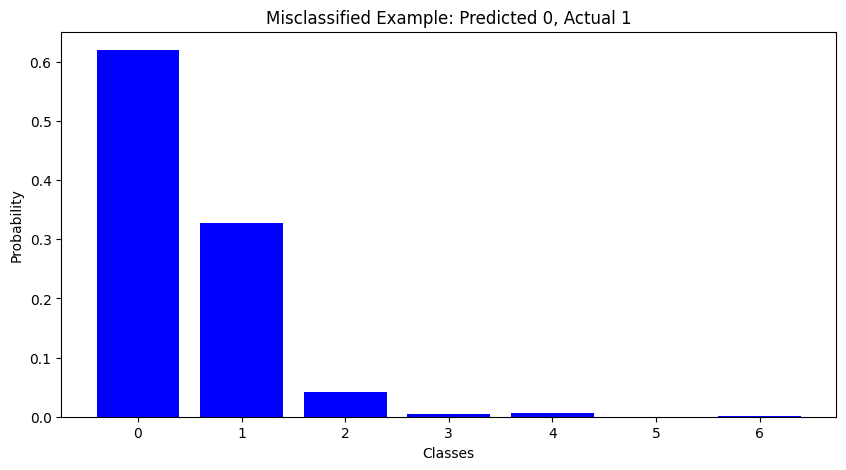

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Set the model in evaluation mode (no gradient computation)
model.eval()

# Disable gradient computation for the following block of code
with torch.no_grad():
    # Iterate over the test data loader, which provides batches of test data
    for inputs, labels in test_loader:
        # Forward pass: get predictions from the model
        outputs = model(inputs)

        # Calculate class probabilities using softmax activation
        probabilities = F.softmax(outputs, dim=1)

        # Find the predicted class for each example in the batch
        _, predicted = torch.max(outputs, 1)

        # Find misclassified examples by comparing predicted labels to true labels
        misclassified_idx = (predicted != labels).nonzero(as_tuple=True)[0]

        # Check if there are any misclassified examples in this batch
        if misclassified_idx.size(0) > 0:
            # Take the first misclassified example (you can adjust this logic if needed)
            misclassified_idx = misclassified_idx[0]

            # Retrieve the misclassified example, true label, predicted label, and class probabilities
            misclassified_example = inputs[misclassified_idx]
            true_label = labels[misclassified_idx]
            predicted_label = predicted[misclassified_idx]
            example_probabilities = probabilities[misclassified_idx]

            # Break out of the loop since we've found a misclassified example
            break

# Create a bar plot to visualize the class probabilities of the misclassified example
plt.figure(figsize=(10, 5))
plt.bar(range(num_classes), example_probabilities.numpy(), color='blue')
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.title(f'Misclassified Example: Predicted {predicted_label}, Actual {true_label}')
plt.show()

Reflection:

After running the above codes, we can compare the MSE for regression and accuracy for classification. Typically, for a problem like this, regression might not be the most suitable approach as it predicts continuous values, and we are interested in predicting discrete class labels. Classification might work better, especially when we want to predict specific categories or numbers of victims.

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


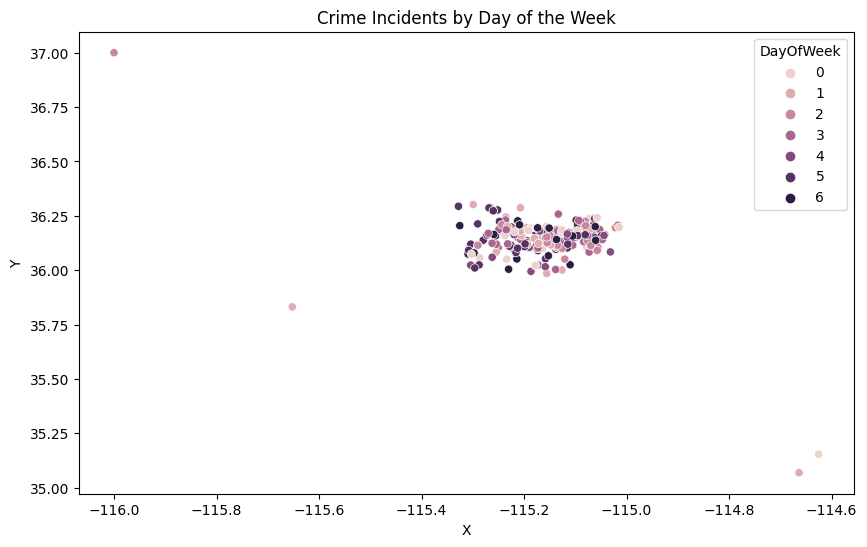

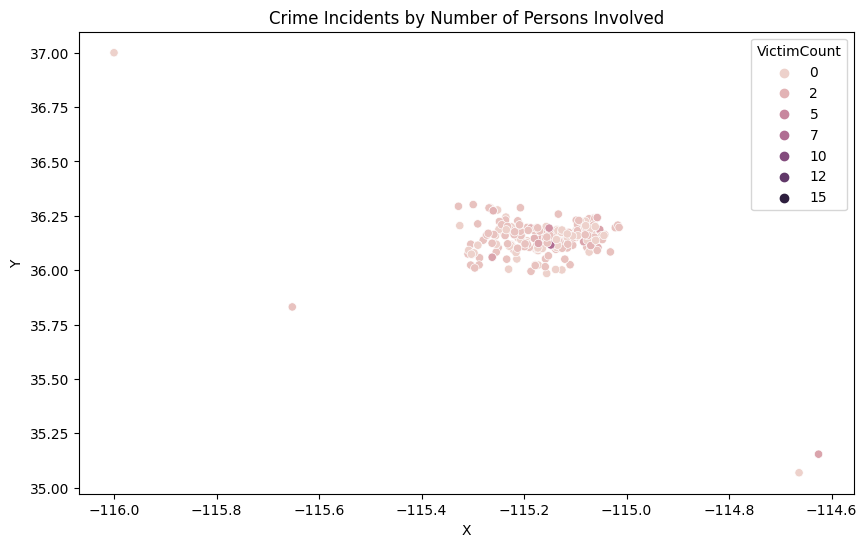

In [ ]:
# Scatter plot with color indicating day of the week
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='X', y='Y', hue='DayOfWeek')
plt.title("Crime Incidents by Day of the Week")
plt.show()

# Scatter plot with color indicating number of persons involved
plt.figure(figsize=(10, 6))
sns.scatterplot(data=orig_df, x='X', y='Y', hue='VictimCount')
plt.title("Crime Incidents by Number of Persons Involved")
plt.show()



In [ ]:
# Calculate crime counts by day of the week and store the result in 'crime_counts_by_day'
crime_counts_by_day = orig_df['ReportedOn'].dt.day_name().value_counts()

# Sort the crime counts in descending order and store the sorted result in 'sorted_crime_counts'
sorted_crime_counts = crime_counts_by_day.sort_values(ascending=False)

# Print the sorted crime counts to the console
print(sorted_crime_counts)


Sunday       51
Saturday     44
Monday       43
Friday       40
Thursday     37
Tuesday      32
Wednesday    28
Name: ReportedOn, dtype: int64


**What days are more frequent?**

Based on the data presented, Sunday emerges as the day with the highest frequency of crimes, recording 51 incidents. This is closely followed by Saturday with 44 incidents and Monday with 43 incidents. In contrast, Wednesday reports the lowest crime rate with 28 incidents. This trend indicates an increase in criminal activities during the weekends and at the beginning of the week, while a noticeable decrease is observed mid-week.